<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-on-deep–coverage-data-does-not-necessarily-improve-denoising" data-toc-modified-id="Training-on-deep–coverage-data-does-not-necessarily-improve-denoising-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training on deep–coverage data does not necessarily improve denoising</a></span></li><li><span><a href="#Synthetic-data" data-toc-modified-id="Synthetic-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Synthetic data</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Increasing-number-of-filters" data-toc-modified-id="Increasing-number-of-filters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Increasing number of filters</a></span></li><li><span><a href="#Increasing-number-of-conv-layers" data-toc-modified-id="Increasing-number-of-conv-layers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Increasing number of conv layers</a></span></li><li><span><a href="#Increasing-number-of-dense-layers" data-toc-modified-id="Increasing-number-of-dense-layers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Increasing number of dense layers</a></span></li><li><span><a href="#A-&quot;pure&quot;-(versus-mixture)-model-fits-worse-but-can-denoise-just-as-well,-if-not-better" data-toc-modified-id="A-&quot;pure&quot;-(versus-mixture)-model-fits-worse-but-can-denoise-just-as-well,-if-not-better-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>A "pure" (versus mixture) model fits worse but can denoise just as well, if not better</a></span></li><li><span><a href="#More-Poisson-components" data-toc-modified-id="More-Poisson-components-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>More Poisson components</a></span></li><li><span><a href="#To-Do" data-toc-modified-id="To-Do-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>To Do</a></span></li></ul></div>

## Training on deep–coverage data does not necessarily improve denoising

Poisson noise can be reduced by increasing the mean depth. But does this improve denoising? In this notebook, I show an example where denoising is not improved because variance in depth of the positive class is determined by the variance in the rate parameters of that class, not poisson noise. 


## Synthetic data

In [1]:
import numpy as np
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])

sequence_length = 30

def build_positive_sequences(number_positive_examples_=5000):
    motif_plus_background = np.hstack([np.ones((4, (sequence_length-motif.shape[1])//2)), 
                                       motif,
                                       np.ones((4, (sequence_length-motif.shape[1])//2))])

    positive_examples = \
    np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                               size=number_positive_examples_, 
                               p=motif_plus_background[:,position]/float(np.sum(motif_plus_background[:,position]))) 
              for position in range(sequence_length)]).transpose()

    sequences_positive_ = []
    for positive_example in positive_examples: 
        sequences_positive_.append(''.join(positive_example))
        
    return sequences_positive_

def build_negative_sequences(number_negative_examples_=995000):
    negative_examples_ = \
    np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                               size=number_negative_examples_, 
                               p=np.array([1,1,1,1])/4.0) 
              for position in range(sequence_length)]).transpose()

    sequences_negative_ = []
    for negative_example in negative_examples_: 
        sequences_negative_.append(''.join(negative_example))
        
    return sequences_negative_


def coefficient_vector(motif_): # \pi_i(s)
    if motif_:
        return np.array([0.1, 0.7, 0.1, 0.1])
    else: 
        return np.array([0, 0, 0, 1])

def sample_rates(motif_, number_of_examples, rate_vector_): 
    components = np.random.choice(a=len(coefficient_vector(True)), size=number_of_examples, p=coefficient_vector(motif_))
    return np.array([rate_vector_(motif_)[component] for component in components])

def compute_true_mean(motif_, rate_vector_): 
    return np.dot(coefficient_vector(motif_), rate_vector_(motif_))

import pandas as pd
from collections import OrderedDict 

def rate_vector_new(motif_): # \lambda_i(s)
    if motif_: 
        return np.array([300, 400, 500, 600])
    else: 
        return np.array([0, 0, 0, 1000])

def build_observed_depths(motif_, number_examples_, rate_vector_):    
    rates = sample_rates(motif_, number_examples_, rate_vector_)
    # https://github.com/numpy/numpy/issues/7843 ...
    return np.random.poisson(lam=rates[:, np.newaxis], size=(len(rates), 1)) 

def build_data_frames(rate_vector_): 
    sequences_positive_ = build_positive_sequences(5000)
    sequences_negative_ = build_negative_sequences(5000)

    observed_depths_positive_ = build_observed_depths(motif_=True, number_examples_=len(sequences_positive_), rate_vector_=rate_vector_)
    observed_depths_negative_ = build_observed_depths(motif_=False, number_examples_=len(sequences_negative_), rate_vector_=rate_vector_)

    df = pd.DataFrame(OrderedDict([
        ('sequence', np.concatenate((sequences_positive_, sequences_negative_))),    
        ('class', [1]*len(sequences_positive_) + [0]*len(sequences_negative_)),
        ('true_coefficients',[np.array_str(coefficient_vector(motif_=True))]*len(sequences_positive_) + [np.array_str(coefficient_vector(motif_=False))]*len(sequences_negative_)),
        ('true_rates',[np.array_str(rate_vector_(motif_=True))]*len(sequences_positive_) + [np.array_str(rate_vector_(motif_=False))]*len(sequences_negative_)),
        ('true_mean',[compute_true_mean(motif_=True, rate_vector_=rate_vector_)]*len(sequences_positive_) + [compute_true_mean(motif_=False, rate_vector_=rate_vector_)]*len(sequences_negative_)),
        ('observed_depth', list(observed_depths_positive_[:,0]) + list(observed_depths_negative_[:,0]))
    ]))

    # add fake genomic positions
    df['position'] = np.random.permutation(len(df))

    # shuffle data
    df = df.sample(frac=1) 

    # split data
    test_dev_sets_size = min(1000, int(0.1*len(df)))

    # make copies to avoid settingwithcopywarning: https://www.dataquest.io/blog/settingwithcopywarning
    df_test = df[:test_dev_sets_size].copy()
    df_dev = df[test_dev_sets_size:2*test_dev_sets_size].copy()
    df_train = df[2*test_dev_sets_size:].copy()
    
    return df_test, df_dev, df_train


In [2]:
data_deep_test, data_deep_dev, data_deep_train = build_data_frames(rate_vector_new)

data_deep_train.head()


,sequence,class,true_coefficients,true_rates,true_mean,observed_depth,position
9111,AGCGTTACTTCGTTATCGGATCCGGAAATG,0,[0 0 0 1],[ 0 0 0 1000],1000.0,938,2926
8258,TATGATTAGAGAGCAGAGTCTGCCTTCGGC,0,[0 0 0 1],[ 0 0 0 1000],1000.0,1014,6374
1768,ACCAGTGGAAGGAAGGAAGGAAGGAGATAG,1,[0.1 0.7 0.1 0.1],[300 400 500 600],420.0,403,7532
3155,TCAATAGGAAGGAAGGAAGGAAGGGTAACC,1,[0.1 0.7 0.1 0.1],[300 400 500 600],420.0,380,3706
7903,CTCAGAGGGCAAAGTGTTTCAATCCCCAGA,0,[0 0 0 1],[ 0 0 0 1000],1000.0,1010,5140


## Baseline model

In [3]:
from tensorflow.keras.backend import clear_session
import tensorflow as tf 
import tensorflow_probability as tfp 

from tensorflow import enable_eager_execution
enable_eager_execution()

def build_baseline_model():
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=1, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d)

    flatten = tfkl.Flatten()(dropout)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(flatten)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=0.02),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

from load_preprocess_data import _preprocess_conv1d
from tensorflow.keras.callbacks import Callback
tfd = tfp.distributions

class CustomHistory(Callback):
    def __init__(self, data_train_, data_dev_, data_test_):
        self.data_train_ = data_train_
        self.data_dev_ = data_dev_
        self.data_test_ = data_test_
        
    # loss WITHOUT L1 or L2 regularization,
    # which is appropriate for assessing the extent to which the model suffers from bias and variance
    def loss(self, data_):
        X, y = _preprocess_conv1d(data_)
        # invoking "model(X)" guarantees that loss is computed without dropout 
        training_joint_distribution = tfd.Independent(self.model(X), reinterpreted_batch_ndims=1)
        training_log_likelihood = training_joint_distribution.log_prob(y)
        return -training_log_likelihood.numpy()/len(X)

    def on_train_begin(self, logs={}):
        self.epochs = []
        self.train_losses = []
        self.dev_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.train_losses.append(self.loss(self.data_train_))
        self.dev_losses.append(self.loss(self.data_dev_))
        self.test_losses.append(self.loss(self.data_test_))
        
batch_size = 100

def train(model_, data_train_, data_dev_, data_test_, number_epochs=100):     
    custom_history = CustomHistory(data_train_, data_dev_, data_test_)

    X_train_, y_train_ = _preprocess_conv1d(data_train_)
    X_dev_, y_dev_ = _preprocess_conv1d(data_dev_)
    
    standard_history = model_.fit(X_train_, 
                                 y_train_, 
                                 validation_data=(X_dev_, y_dev_),
                                 batch_size=batch_size,
                                 epochs=number_epochs,
                                 steps_per_epoch=len(X_train_)//batch_size, 
                                 callbacks=[custom_history]) 
    return standard_history, custom_history




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
baseline_model_deep = build_baseline_model()

baseline_model_deep_standard_history, baseline_model_deep_custom_history = train(baseline_model_deep, data_deep_train, data_deep_dev, data_deep_test) 


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.random.categorical instead.
inputs [<tf.Tensor 'input_1:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 1)             72        
_________________________________________________________________
dropout (Dropout)            (None, 13, 1)             0         
_________________________________________________________________
flatten (Flatten)       

80/80 [==============================] - 2s 29ms/step - loss: 8.3606 - val_loss: 18.9112
Epoch 57/100
80/80 [==============================] - 2s 29ms/step - loss: 7.7350 - val_loss: 14.8675
Epoch 58/100
80/80 [==============================] - 2s 30ms/step - loss: 7.2095 - val_loss: 17.7443
Epoch 59/100
80/80 [==============================] - 2s 30ms/step - loss: 6.9323 - val_loss: 18.4445
Epoch 60/100
80/80 [==============================] - 2s 30ms/step - loss: 6.7996 - val_loss: 18.3177
Epoch 61/100
80/80 [==============================] - 2s 29ms/step - loss: 6.7172 - val_loss: 18.5246
Epoch 62/100
80/80 [==============================] - 2s 29ms/step - loss: 6.6817 - val_loss: 18.1510
Epoch 63/100
80/80 [==============================] - 2s 29ms/step - loss: 6.6603 - val_loss: 17.4759
Epoch 64/100
80/80 [==============================] - 2s 29ms/step - loss: 6.6091 - val_loss: 18.2115
Epoch 65/100
80/80 [==============================] - 2s 30ms/step - loss: 6.5643 - val_loss: 1

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_history(models, loss_max=50):
    plt.figure(figsize=(10,5))    
    for name, standard_history, custom_history in models:
        plt.title(name)
        plt.plot(standard_history.epoch, 
                 standard_history.history['loss'], 
                 label='train loss that is optimized')
        plt.plot(custom_history.epochs, 
                 custom_history.train_losses, 
                 label='train loss', 
                 color='black')
        plt.plot(custom_history.epochs, 
                 custom_history.dev_losses, 
                 label='dev loss')
        plt.plot(custom_history.epochs, 
                 custom_history.test_losses, 
                 label='test loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(standard_history.epoch)])
        plt.ylim(0, loss_max)
      

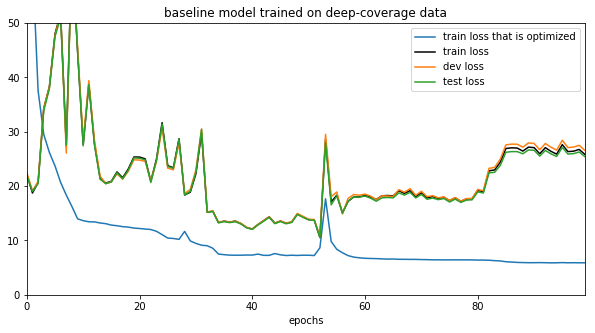

In [6]:
plot_history([('baseline model trained on deep-coverage data', baseline_model_deep_standard_history, baseline_model_deep_custom_history)])


In [7]:
def compute_coefficients_rates(df, model_): 
    X_, _ = _preprocess_conv1d(df)    
    df['predicted_coefficients'] = list(model_(X_).mixture_distribution.probs.numpy())
    df['predicted_rates'] = list(model_(X_).components_distribution.distribution.rate.numpy().squeeze())

pd.set_option('max_colwidth', 100)


In [8]:
compute_coefficients_rates(data_deep_train, baseline_model_deep)
data_deep_train.head()


,sequence,class,true_coefficients,true_rates,true_mean,observed_depth,position,predicted_coefficients,predicted_rates
9111,AGCGTTACTTCGTTATCGGATCCGGAAATG,0,[0 0 0 1],[ 0 0 0 1000],1000.0,938,2926,"[0.00013493454, 0.00021979689, 0.0400838, 0.00061924494, 0.95894223]","[4.916588, 8.748015, 423.3875, 38.388275, 998.8668]"
8258,TATGATTAGAGAGCAGAGTCTGCCTTCGGC,0,[0 0 0 1],[ 0 0 0 1000],1000.0,1014,6374,"[0.00013493454, 0.00021979689, 0.0400838, 0.00061924494, 0.95894223]","[4.916588, 8.748015, 423.3875, 38.388275, 998.8668]"
1768,ACCAGTGGAAGGAAGGAAGGAAGGAGATAG,1,[0.1 0.7 0.1 0.1],[300 400 500 600],420.0,403,7532,"[3.215259e-05, 0.3016093, 0.013643406, 0.07254591, 0.6121692]","[4.192763, 158.09561, 3275.188, 182.19667, 637.2931]"
3155,TCAATAGGAAGGAAGGAAGGAAGGGTAACC,1,[0.1 0.7 0.1 0.1],[300 400 500 600],420.0,380,3706,"[3.9878385e-05, 0.26330072, 0.010693772, 0.07250028, 0.65346533]","[4.328992, 156.92389, 3247.4045, 182.00034, 638.6011]"
7903,CTCAGAGGGCAAAGTGTTTCAATCCCCAGA,0,[0 0 0 1],[ 0 0 0 1000],1000.0,1010,5140,"[9.619398e-05, 0.0001543916, 0.03341765, 0.0004371824, 0.9658946]","[4.821451, 8.758967, 441.33456, 43.13403, 1000.3592]"


In [9]:
normalized_lower_depth_threshold, normalized_upper_depth_threshold = 0.8, 1.2

def colors(df): 
    colors = []
    for class_membership in df['class']: 
        colors.append('red' if class_membership else 'green')
    return colors

def correct(df, model):
    number_examples_ = 1000
    if len(df) > number_examples_: 
        df = df.sample(number_examples_).copy()        
    X, _ = _preprocess_conv1d(df)
    # pd.options.mode.chained_assignment = None  # default='warn'
    df['predicted_mean'] = list(model(X).mean().numpy().squeeze())
    df['corrected_depth'] = df['observed_depth']/df['predicted_mean']
    return df

def performance_metric(df, observed_mean_depth):
    cond_lower = df['corrected_depth'].values > normalized_lower_depth_threshold
    cond_upper = df['corrected_depth'].values < normalized_upper_depth_threshold
    prob_corrected = np.sum(cond_lower & cond_upper)/float(len(df))
    cond_lower = df['observed_depth'].values > normalized_lower_depth_threshold*observed_mean_depth
    cond_upper = df['observed_depth'].values < normalized_upper_depth_threshold*observed_mean_depth
    prob_observed = np.sum(cond_lower & cond_upper)/float(len(df))
    return prob_corrected/prob_observed

def evaluate_performance(df_train, df, model, rate_vector_):
    df = correct(df, model)
    
    figsize=(10,5)
    normalized_max_depth = 2

    df_well_corrected = df[
        (df['corrected_depth'] > normalized_lower_depth_threshold) 
        &
        (df['corrected_depth'] < normalized_upper_depth_threshold)         
    ]

    observed_mean_depth = np.mean(df_train[df_train['class']==0]['observed_depth'])

    plt.figure(figsize=figsize)
    plt.scatter(df[df['class'] == 1]['position'], 
                df[df['class'] == 1]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from positive class)',
                c='red',
                alpha=0.5)
    plt.scatter(df[df['class'] == 0]['position'], 
                df[df['class'] == 0]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from negative class)',
                c='green',
                alpha=0.5)
    plt.scatter(df['position'], 
                df['observed_depth'].values/observed_mean_depth,
                marker='o', facecolors='none', edgecolors='black', linewidth=0.25,
                label='uncorrected depth')
    plt.plot([0, max(df['position'])], [normalized_lower_depth_threshold, normalized_lower_depth_threshold], '--k')
    plt.plot([0, max(df['position'])], [normalized_upper_depth_threshold, normalized_upper_depth_threshold], '--k')
    plt.xlabel('index of example')
    _ = plt.legend(loc='upper right')
    plt.ylim([0, normalized_max_depth])
    plt.title('performance_metric = {:.3f}'.format(performance_metric(df, observed_mean_depth)))

    plt.figure(figsize=figsize)    
    plt.scatter(df['predicted_mean']/observed_mean_depth, 
                df['observed_depth']/observed_mean_depth, 
                label=None,
                c=colors(df),
                alpha=0.5)
    plt.scatter(df_well_corrected['predicted_mean']/observed_mean_depth, 
                df_well_corrected['observed_depth']/observed_mean_depth, 
                label='well-corrected examples',
                marker='o', facecolors='none', edgecolors='k',
                alpha=0.5)
    plt.xlabel('predicted mean depth (normalized)')
    plt.ylabel('observed depth (normalized)')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_upper_depth_threshold)*normalized_max_depth], 
             '--k')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_lower_depth_threshold)*normalized_max_depth], 
             '--k')
    true_mean_positive = compute_true_mean(motif_=True, rate_vector_=rate_vector_)
    plt.plot([true_mean_positive/observed_mean_depth, true_mean_positive/observed_mean_depth], 
             [0, normalized_max_depth], 
             'red', label='true mean depth for positive class (normalized)')    
    true_mean_negative = compute_true_mean(motif_=False, rate_vector_=rate_vector_)
    plt.plot([true_mean_negative/observed_mean_depth, true_mean_negative/observed_mean_depth], 
             [0, normalized_max_depth], 
             'green', label='true mean depth for negative class (normalized)')    
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')


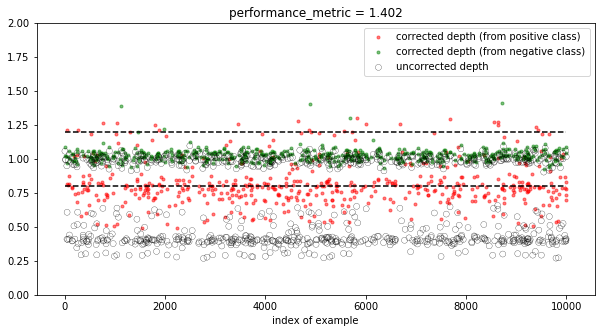

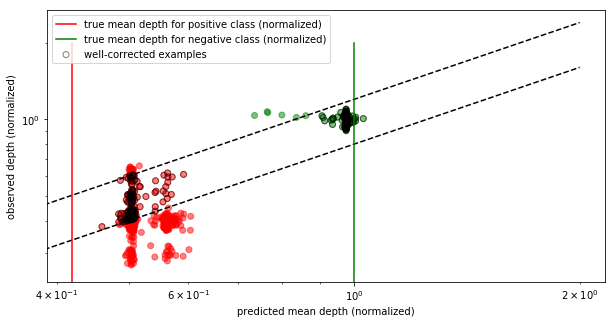

In [10]:
evaluate_performance(data_deep_train, data_deep_train, baseline_model_deep, rate_vector_new)


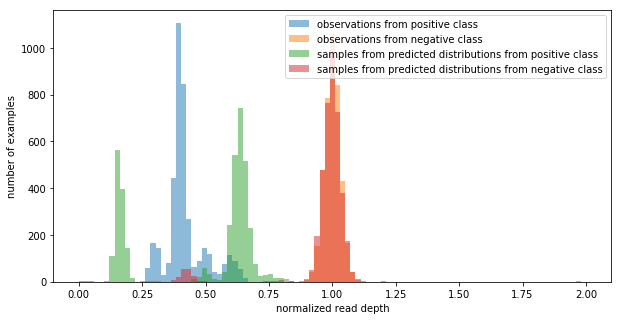

In [27]:
def plot_depth_distribution(df, model): 
    plt.figure(figsize=(10,5))    
    bins = np.linspace(0, 2, 100)

    df = df.copy()
    X, _ = _preprocess_conv1d(df)
    df['predicted_sample'] = list(model(X).sample().numpy().squeeze())

    df_negative = df[df['class']==0]
    df_positive = df[df['class']==1]
    mean_depth = np.mean(df_negative['observed_depth'])

    plt.hist(df_positive['observed_depth']/mean_depth, bins, alpha=0.5, label='observations from positive class')
    plt.hist(df_negative['observed_depth']/mean_depth, bins, alpha=0.5, label='observations from negative class')

    plt.hist(df_positive['predicted_sample']/mean_depth, bins, alpha=0.5, label='samples from predicted distributions from positive class')
    plt.hist(df_negative['predicted_sample']/mean_depth, bins, alpha=0.5, label='samples from predicted distributions from negative class')

    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('linear')
    
plot_depth_distribution(data_deep_train, baseline_model_deep)

## Increasing number of filters 

In [11]:
def build_model_1(learning_rate=0.02):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=10, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d)

    flatten = tfkl.Flatten()(dropout)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(flatten)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)
    
    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_1 = build_model_1(learning_rate=0.01)

model_1_standard_history, model_1_custom_history = train(model_1, data_deep_train, data_deep_dev, data_deep_test, number_epochs=100) 


inputs [<tf.Tensor 'input_1_1:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_1/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 10)            720       
_________________________________________________________________
dropout (Dropout)            (None, 13, 10)            0         
_________________________________________________________________
flatten (Flatten)            (None, 130)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1310      
_________________________________________________________________
mixtu

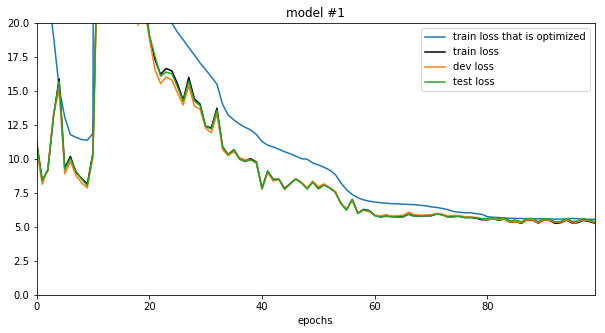

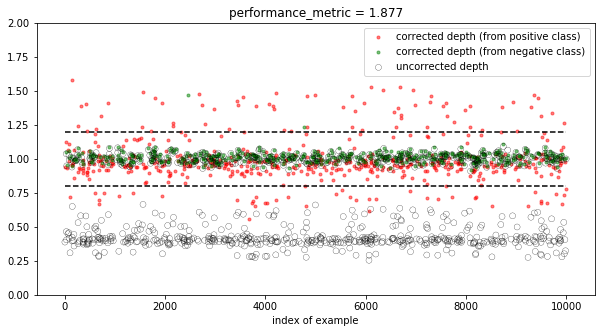

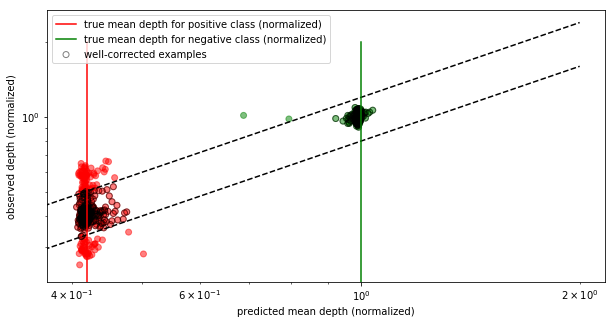

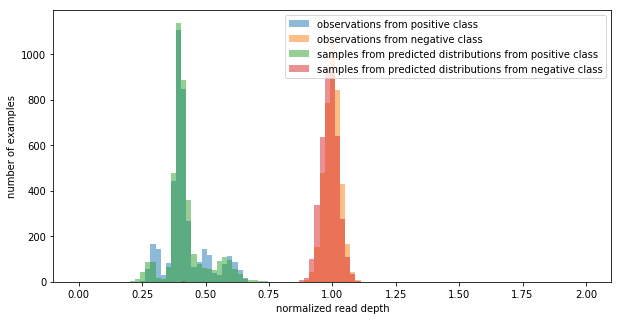

In [28]:
plot_history([('model #1', model_1_standard_history, model_1_custom_history)], loss_max=20)
evaluate_performance(data_deep_train, data_deep_train, model_1, rate_vector_new)
plot_depth_distribution(data_deep_train, model_1)

## Increasing number of conv layers

In [13]:
def build_model_2(learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=10, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    conv1d_2 = tfkl.Conv1D(
        filters=10, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1d)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d_2)

    flatten = tfkl.Flatten()(dropout)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(flatten)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)
    
    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_2 = build_model_2()

model_2_standard_history, model_2_custom_history = train(model_2, data_deep_train, data_deep_dev, data_deep_test, number_epochs=100) 


inputs [<tf.Tensor 'input_1_2:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_2/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 10)            720       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 10)             600       
_________________________________________________________________
dropout (Dropout)            (None, 8, 10)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense

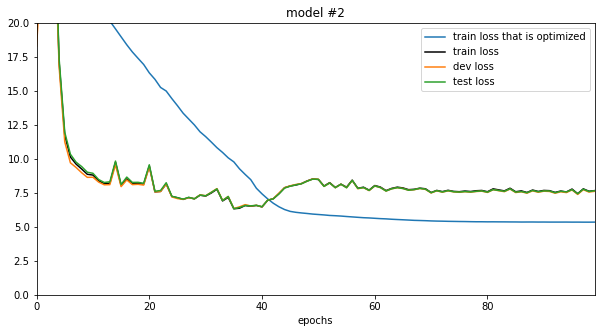

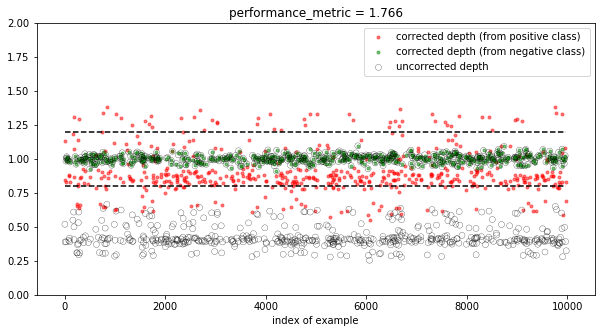

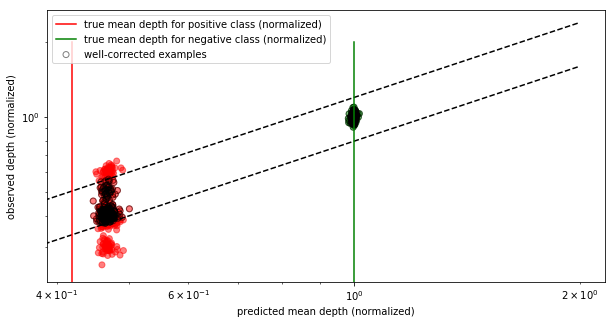

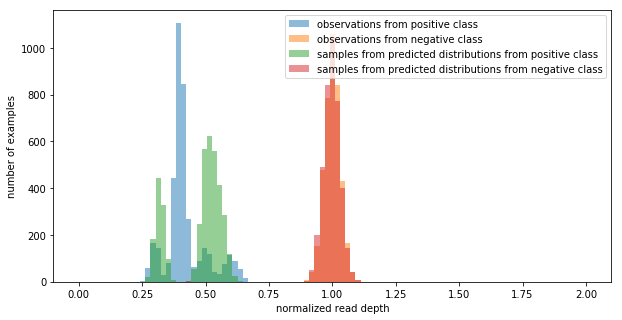

In [29]:
plot_history([('model #2', model_2_standard_history, model_2_custom_history)], loss_max=20)
evaluate_performance(data_deep_train, data_deep_train, model_2, rate_vector_new)
plot_depth_distribution(data_deep_train, model_2)

## Increasing number of dense layers

In [15]:
def build_model_3(learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=10, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    conv1d_2 = tfkl.Conv1D(
        filters=10, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1d)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d_2)

    flatten = tfkl.Flatten()(dropout)

    dense = tfkl.Dense(40, activation='relu')(flatten)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_3 = build_model_3()

model_3_standard_history, model_3_custom_history = train(model_3, data_deep_train, data_deep_dev, data_deep_test, number_epochs=100) 


inputs [<tf.Tensor 'input_1_3:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_3/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 10)            720       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 10)             600       
_________________________________________________________________
dropout (Dropout)            (None, 8, 10)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense

,sequence,class,true_coefficients,true_rates,true_mean,observed_depth,position,predicted_coefficients,predicted_rates
9111,AGCGTTACTTCGTTATCGGATCCGGAAATG,0,[0 0 0 1],[ 0 0 0 1000],1000.0,938,2926,"[0.0011929902, 9.310454e-09, 0.9982053, 0.00022592099, 0.00037561377]","[421.49362, 10.264871, 989.36774, 326.09088, 562.47003]"
8258,TATGATTAGAGAGCAGAGTCTGCCTTCGGC,0,[0 0 0 1],[ 0 0 0 1000],1000.0,1014,6374,"[0.0010017542, 9.135494e-09, 0.9984242, 0.00019551066, 0.0003784312]","[403.3205, 9.735104, 1004.4201, 304.30457, 538.07336]"
1768,ACCAGTGGAAGGAAGGAAGGAAGGAGATAG,1,[0.1 0.7 0.1 0.1],[300 400 500 600],420.0,403,7532,"[0.7147706, 8.756248e-07, 0.08667241, 0.102457345, 0.09609877]","[405.69336, 10.821538, 532.9726, 305.0868, 586.951]"
3155,TCAATAGGAAGGAAGGAAGGAAGGGTAACC,1,[0.1 0.7 0.1 0.1],[300 400 500 600],420.0,380,3706,"[0.7052193, 9.1838643e-07, 0.09191886, 0.10461308, 0.09824777]","[407.78723, 10.968088, 538.77295, 304.62076, 585.2244]"
7903,CTCAGAGGGCAAAGTGTTTCAATCCCCAGA,0,[0 0 0 1],[ 0 0 0 1000],1000.0,1010,5140,"[0.00051185896, 6.626003e-09, 0.9991572, 0.00011913836, 0.00021195266]","[404.91064, 10.24687, 1006.32043, 311.16226, 546.7618]"


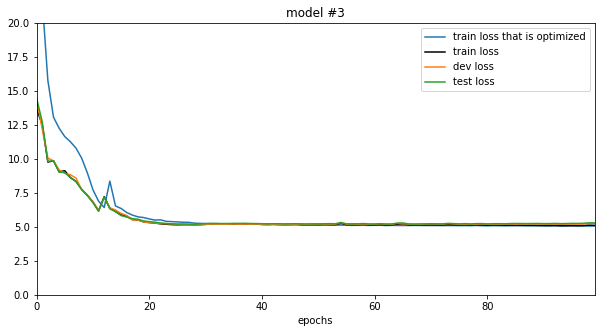

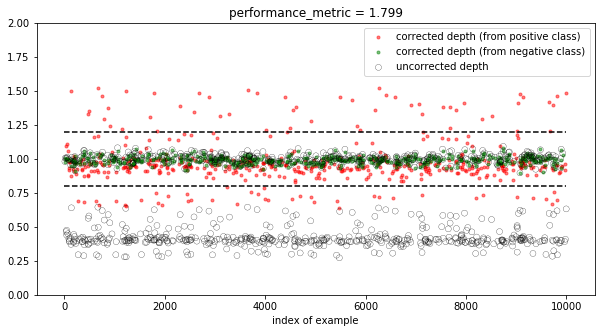

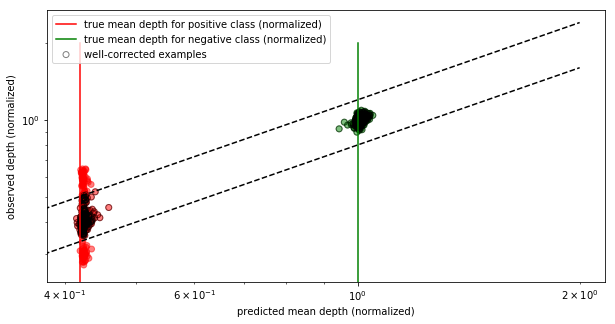

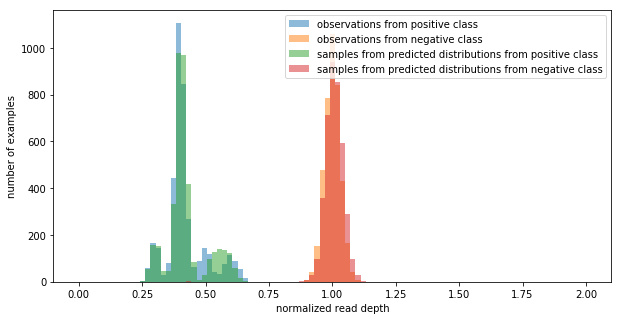

In [30]:
plot_history([('model #3', model_3_standard_history, model_3_custom_history)], loss_max=20)
evaluate_performance(data_deep_train, data_deep_train, model_3, rate_vector_new)
compute_coefficients_rates(data_deep_train, model_3)
plot_depth_distribution(data_deep_train, model_3)
data_deep_train.head()



Note that, though the model does a great job of predicting depth, it's ability to denoise is limited by the fact that a lot of the variation in depth in the positive class is not sequence-dependent.



## A "pure" (versus mixture) model fits worse but can denoise just as well, if not better

In [33]:
def build_model_4(learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=10, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    conv1d_2 = tfkl.Conv1D(
        filters=10, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1d)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d_2)

    flatten = tfkl.Flatten()(dropout)

    dense = tfkl.Dense(40, activation='relu')(flatten)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 1
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_4 = build_model_4(learning_rate=0.005)

model_4_standard_history, model_4_custom_history = train(model_4, data_deep_train, data_deep_dev, data_deep_test, number_epochs=100) 


inputs [<tf.Tensor 'input_1_8:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_8/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 10)            720       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 10)             600       
_________________________________________________________________
dropout (Dropout)            (None, 8, 10)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense

Epoch 66/100
80/80 [==============================] - 6s 70ms/step - loss: 7.6101 - val_loss: 8.0250
Epoch 67/100
80/80 [==============================] - 6s 70ms/step - loss: 7.6017 - val_loss: 8.0079
Epoch 68/100
80/80 [==============================] - 6s 70ms/step - loss: 7.5895 - val_loss: 7.9816
Epoch 69/100
80/80 [==============================] - 6s 70ms/step - loss: 7.5878 - val_loss: 7.9699
Epoch 70/100
80/80 [==============================] - 6s 70ms/step - loss: 7.5739 - val_loss: 7.9702
Epoch 71/100
80/80 [==============================] - 6s 70ms/step - loss: 7.5736 - val_loss: 7.9829
Epoch 72/100
80/80 [==============================] - 6s 70ms/step - loss: 7.5632 - val_loss: 7.9866
Epoch 73/100
80/80 [==============================] - 6s 71ms/step - loss: 7.5514 - val_loss: 7.9622
Epoch 74/100
80/80 [==============================] - 6s 72ms/step - loss: 7.5433 - val_loss: 7.9837
Epoch 75/100
80/80 [==============================] - 6s 70ms/step - loss: 7.5318 - val_los

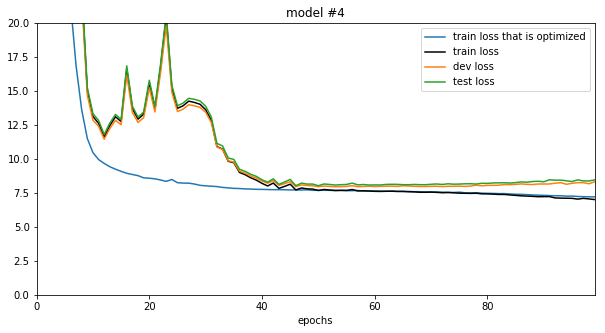

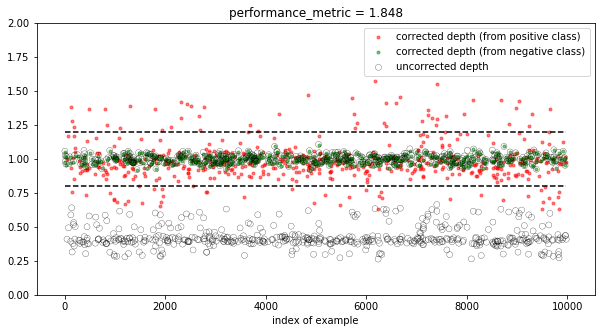

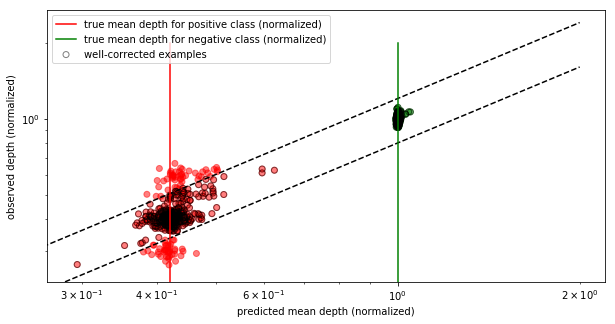

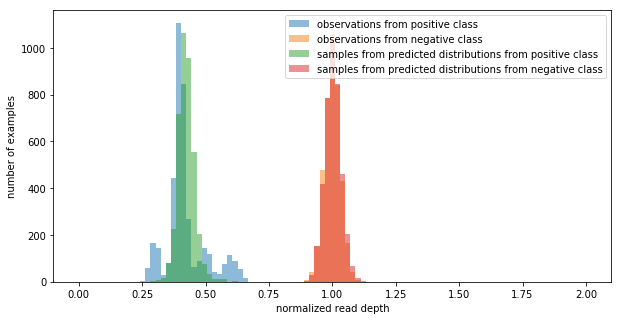

In [35]:
plot_history([('model #4', model_4_standard_history, model_4_custom_history)], loss_max=20)
evaluate_performance(data_deep_train, data_deep_train, model_4, rate_vector_new)
compute_coefficients_rates(data_deep_train, model_4)
data_deep_train.head()
plot_depth_distribution(data_deep_train, model_4)

## More Poisson components

In [22]:
def build_model_5(learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=10, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    conv1d_2 = tfkl.Conv1D(
        filters=10, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1d)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d_2)

    flatten = tfkl.Flatten()(dropout)

    dense = tfkl.Dense(40, activation='relu')(flatten)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 50
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_5 = build_model_5(learning_rate=0.005)

model_5_standard_history, model_5_custom_history = train(model_5, data_deep_train, data_deep_dev, data_deep_test, number_epochs=100) 


inputs [<tf.Tensor 'input_1_7:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_7/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 10)            720       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 10)             600       
_________________________________________________________________
dropout (Dropout)            (None, 8, 10)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense

Epoch 66/100
80/80 [==============================] - 7s 91ms/step - loss: 5.0997 - val_loss: 5.1247
Epoch 67/100
80/80 [==============================] - 7s 93ms/step - loss: 5.0998 - val_loss: 5.1246
Epoch 68/100
80/80 [==============================] - 12s 146ms/step - loss: 5.0995 - val_loss: 5.1242
Epoch 69/100
80/80 [==============================] - 9s 108ms/step - loss: 5.0990 - val_loss: 5.1255
Epoch 70/100
80/80 [==============================] - 10s 120ms/step - loss: 5.1002 - val_loss: 5.1268
Epoch 71/100
80/80 [==============================] - 8s 102ms/step - loss: 5.0981 - val_loss: 5.1254
Epoch 72/100
80/80 [==============================] - 9s 113ms/step - loss: 5.0944 - val_loss: 5.1252
Epoch 73/100
80/80 [==============================] - 9s 112ms/step - loss: 5.0967 - val_loss: 5.1310
Epoch 74/100
80/80 [==============================] - 8s 106ms/step - loss: 5.0978 - val_loss: 5.1276
Epoch 75/100
80/80 [==============================] - 8s 97ms/step - loss: 5.0961 

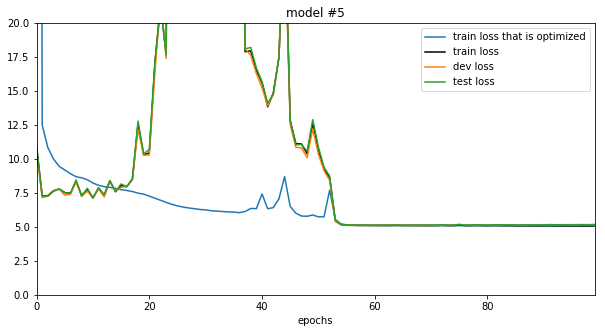

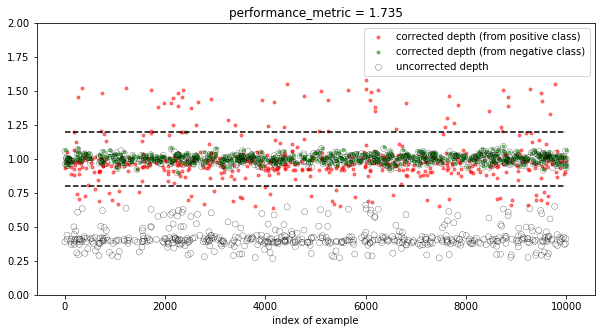

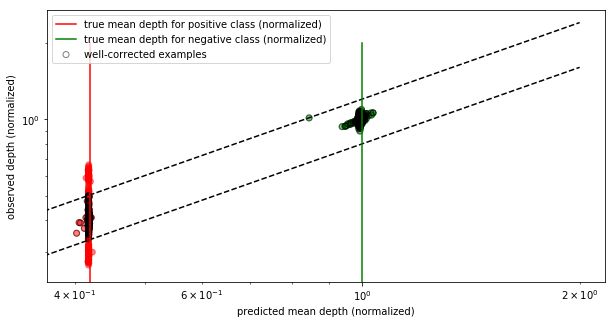

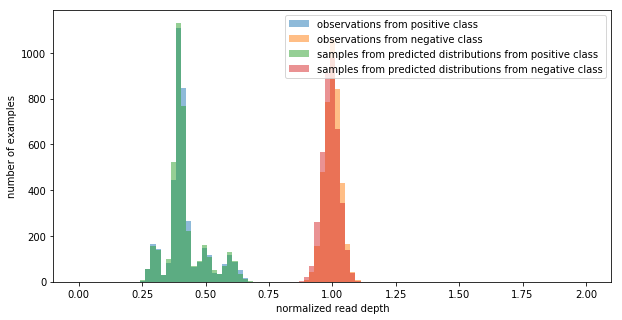

In [38]:
plot_history([('model #5', model_5_standard_history, model_5_custom_history)], loss_max=20)
evaluate_performance(data_deep_train, data_deep_train, model_5, rate_vector_new)
compute_coefficients_rates(data_deep_train, model_5)
data_deep_train.head()
plot_depth_distribution(data_deep_train, model_5)

## To Do

* Is it easier to recover a sequence motif from the learned convolution filters of a mixture model than from a pure model? 
* Apply this "pipeline" to real data by choosing, as positive examples, sequence intervals harboring the CCCGCC motif, which is known to reduce read depth: [Ekblom et al 2014](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-15-467) and [Van den Hoecke et al 2016](https://www.nature.com/articles/srep26314). Also apply to positive-class examples harboring AT repeats, which have also been shown to affect read depth: [Smith et al 2015](https://peerj.com/articles/836/) and [Ross et al 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-r51#Sec2).  
